## Table of Contents

### 1. Data Loading and Preprocessing 
> #### 1.1 Load the Data
> #### 1.2 Define custom dataset and dataloader
> #### 1.3 Data Exploration
### 2. Lane Segmentation using Baseline U-Net
> #### 2.1 Define model architecture
> #### 2.2 Train the model
> #### 2.3 Calculate IoU score
### 3. Lane Segmentation using U-Net with Best practices
> #### 3.0 Define validation and test dataloader
> #### 3.1 Define model architecture
> #### 3.2 Train the model
> #### 3.3 Calculate IoU score
> #### 3.4 Inference on Test dataset

---

### 1. Data Loading and Preprocessing

#### 1.1 Load the Data

In [ ]:
# Upload data from drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip /content/drive/MyDrive/Lane_segment_dataset.zip

Archive:  /content/drive/MyDrive/Lane_segment_dataset.zip
  inflating: data/CamVid/test/0001TP_008550.png  
  inflating: data/CamVid/test/0001TP_008580.png  
  inflating: data/CamVid/test/0001TP_008610.png  
  inflating: data/CamVid/test/0001TP_008640.png  
  inflating: data/CamVid/test/0001TP_008670.png  
  inflating: data/CamVid/test/0001TP_008700.png  
  inflating: data/CamVid/test/0001TP_008730.png  
  inflating: data/CamVid/test/0001TP_008760.png  
  inflating: data/CamVid/test/0001TP_008790.png  
  inflating: data/CamVid/test/0001TP_008820.png  
  inflating: data/CamVid/test/0001TP_008850.png  
  inflating: data/CamVid/test/0001TP_008880.png  
  inflating: data/CamVid/test/0001TP_008910.png  
  inflating: data/CamVid/test/0001TP_008940.png  
  inflating: data/CamVid/test/0001TP_008970.png  
  inflating: data/CamVid/test/0001TP_009000.png  
  inflating: data/CamVid/test/0001TP_009030.png  
  inflating: data/CamVid/test/0001TP_009060.png  
  inflating: data/CamVid/test/0001TP_00909

In [ ]:
# Install required library for U-net model
!pip install -U segmentation-models-pytorch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 7.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 549.1/549.1 kB 26.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 28.1 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16427 sha256=55db7c3e4e9e218124c52bf823350b0ee7938f188726061a509831f765a39691
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60945 sha256=1137c2499e98b9948ef0ae8eb64533f322e2155abc962d679bbff2f12076ff2f
  Stored in directory: /root/.cache/pip/w

In [ ]:
# import libraries and modules
%matplotlib inline

import os
import torch
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image
from random import random

# import pytorch related modules
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import functional as F
from torchvision.transforms import Compose, ToTensor, Resize, Normalize

import segmentation_models_pytorch as smp

In [ ]:
# set seed
seed = 42
np.random.seed(seed)
torch.manual_seed(seed);

In [ ]:
# Create train, val, test datasets by providing respective paths
x_train_dir = '/content/data/CamVid/train'
y_train_dir = '/content/data/CamVid/trainannot'

x_val_dir = '/content/data/CamVid/val'
y_val_dir = '/content/data/CamVid/valannot'

x_test_dir = '/content/data/CamVid/test'
y_test_dir = '/content/data/CamVid/testannot'

#### 1.2 Define custom dataset and dataloader

In [ ]:
# define custom dataset class
class CamVidDataset(Dataset):
    def __init__(self, images_dir, masks_dir=None, transforms=None, preprocessing=False, training_type=None):
        # get all image names
        self.image_names = os.listdir(images_dir)

        # set training type, transforms
        self.training_type = training_type
        self.transforms = transforms
        self.preprocessing=preprocessing

        # get image and target paths
        self.images_paths = []
        self.masks_paths = []
        for image_name in self.image_names:
            self.images_paths.append(os.path.join(images_dir, image_name))
            if self.training_type=="train" or self.training_type=="val":
                self.masks_paths.append(os.path.join(masks_dir, image_name.split('.')[0] + '.png'))
    
    def __getitem__(self, i):
        
        if self.training_type=="train" or self.training_type=="val":
            # read data
            image = Image.open(self.images_paths[i])
            mask = Image.open(self.masks_paths[i])

            # preprocess mask
            mask = np.array(mask)
            mask = (mask == 3)
            mask = Image.fromarray(mask)

            # data augmentation
            ## random horizontal flip
            if random() < 0.5:
                image, mask = F.hflip(image), F.hflip(mask)

            ## apply transforms
            image = self.transforms(image)
            mask = self.transforms(mask)

            ## apply preprocessing
            if self.preprocessing:
                image = Compose([Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225])])(image)
            
            return image, mask
        
        else:
            # read data
            image = Image.open(self.images_paths[i])
            
            # apply transforms
            image = self.transforms(image)

            # apply preprocessing
            if self.preprocessing:
                image = Compose([Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225])])(image)  
            
            return image
        
    def __len__(self):
        return len(self.image_names)

We performed data augmentation by flipping images and masks horizontally.

In [ ]:
# create transform
train_transforms = Compose([
    Resize((224, 224)),
    ToTensor()
])
# create instance of custom dataset
train_dataset = CamVidDataset(
    x_train_dir, 
    y_train_dir, 
    transforms=train_transforms,
    training_type='train'
)
# create dataloader
train_loader = DataLoader(
    train_dataset, 
    batch_size=16,
    num_workers=4
)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


#### 1.3 Data Exploration

In [ ]:
for batch_x, batch_y in train_loader:
    break

In [ ]:
batch_x.shape, batch_y.shape

(torch.Size([16, 3, 224, 224]), torch.Size([16, 1, 224, 224]))

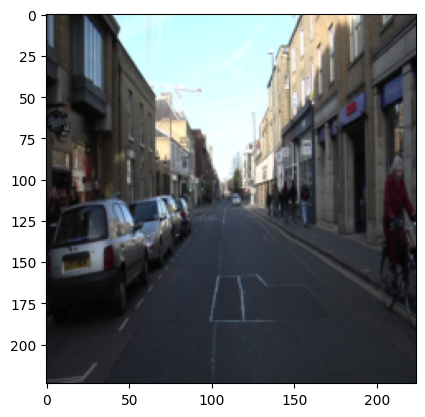

In [ ]:
plt.imshow(np.transpose(batch_x[0], (1, 2, 0)))

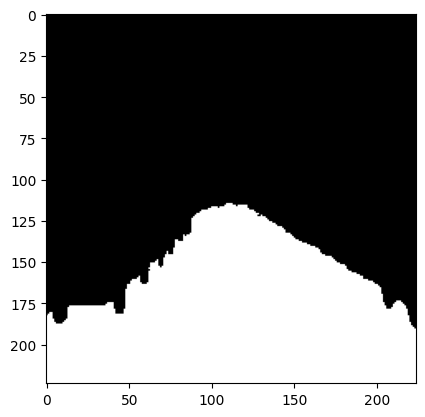

In [ ]:
plt.imshow(batch_y[0].squeeze(), cmap='gray')

In [ ]:
# create instance of custom dataset
train_dataset = CamVidDataset(
    x_train_dir, 
    y_train_dir, 
    transforms=train_transforms,
    preprocessing=True,
    training_type='train'  # We are applying transformations on training set
)
# create dataloader
train_loader = DataLoader(
    train_dataset, 
    batch_size=16,
    num_workers=4
)

### 2. Lane Segmentation using Baseline U-Net


#### 2.1 Define model architecture

In [ ]:
# create segmentation model with pretrained encoder
model = smp.Unet(
    encoder_name='resnet18', 
    encoder_weights='imagenet', 
    classes=1, 
    activation='sigmoid',
)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 88.4MB/s]


model = smp.Unet()   : Model name we want to load
    
 
encoder_weights='imagenet', : Mention dataset name to be used for encoder pretrained weights


classes=1,  :  No. of output classes

activation='sigmoid', 

In [ ]:
# print model
model

Unet(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track

In [ ]:
# check for one iteration of loop
for batch_x, batch_y in train_loader:
    break

In [ ]:
# check model on one image
model.eval()
output = model(batch_x[1].view(1, 3, 224, 224)).detach().numpy()

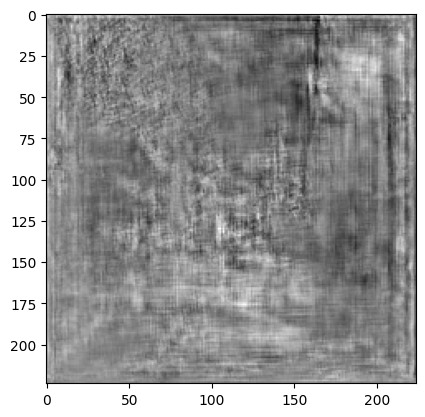

In [ ]:
# print output
plt.imshow(output.squeeze(), cmap='gray')

#### 2.2 Train the model

In [ ]:
# define loss function
criterion = smp.utils.losses.BCELoss()

# define optimizer
optimizer = torch.optim.Adam([parameters for parameters in model.parameters() if parameters.requires_grad], lr=1e-3)

# define evaluation metric
metrics = [
    smp.utils.metrics.IoU(threshold=0.5)
]

AttributeError: ignored

In [ ]:
# define training epoch
train_epoch = smp.utils.train.TrainEpoch(
    model, 
    loss=criterion, 
    metrics=metrics, 
    optimizer=optimizer,
    device='cuda',
    verbose=True,
)

AttributeError: ignored

In [ ]:
max_score = 0

for i in range(0, 5):
    print('\nEpoch: {}'.format(i + 1))
    train_logs = train_epoch.run(train_loader)


Epoch: 1
train: 100%|██████████| 23/23 [00:09<00:00,  2.48it/s, bce_loss - 0.2659, iou_score - 0.7976]

Epoch: 2
train: 100%|██████████| 23/23 [00:09<00:00,  2.52it/s, bce_loss - 0.09914, iou_score - 0.9178]

Epoch: 3
train: 100%|██████████| 23/23 [00:08<00:00,  2.57it/s, bce_loss - 0.06713, iou_score - 0.938]

Epoch: 4
train: 100%|██████████| 23/23 [00:08<00:00,  2.56it/s, bce_loss - 0.05911, iou_score - 0.9399]

Epoch: 5
train: 100%|██████████| 23/23 [00:08<00:00,  2.61it/s, bce_loss - 0.04627, iou_score - 0.9524]


#### 2.3 Calculate IoU score

In [ ]:
# get sample data
image = Image.open('/content/data/CamVid/train/0006R0_f00930.png')
gt_mask = Image.open('/content/data/CamVid/trainannot/0006R0_f00930.png')

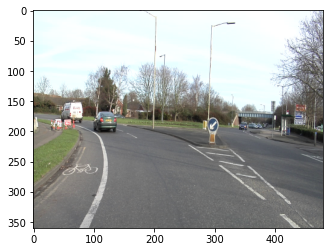

In [ ]:
plt.imshow(image)

In [ ]:
# preprocess mask
gt_mask = np.array(gt_mask)
gt_mask = (gt_mask == 3)
gt_mask = Image.fromarray(gt_mask)

# apply data augmentation
transform = Compose([
            Resize((224, 224)),
            ToTensor()
            ])
        
image = transform(image)

image = Compose([Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225])])(image)

gt_mask = transform(gt_mask)

In [ ]:
model.eval()
output = model(image.view(1, 3, 224, 224).to("cuda")).cpu().detach().numpy()

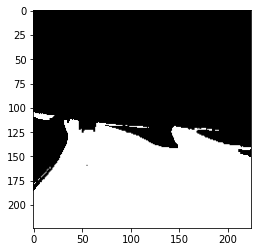

In [ ]:
plt.imshow(gt_mask.squeeze(), cmap='gray')

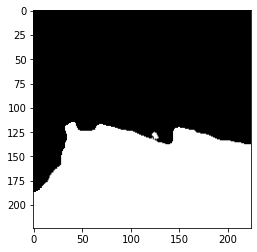

In [ ]:
plt.imshow((output.squeeze() > 0.5).astype(int), cmap='gray')

In [ ]:
# convert predicted mask to flattened numpy array
mask = (output.squeeze() > 0.5).astype(int)
pred = mask.ravel().copy()

# convert ground truth mask to flattened numpy array
gt_mask = gt_mask.cpu().detach().numpy()
target = gt_mask.ravel().copy().astype(int)

# get class indices for Lane
pred_inds = pred == 1
target_inds = target == 1

# calculate intersection
intersection = pred_inds[target_inds].sum()

# calculate union
union = pred_inds.sum() + target_inds.sum() - intersection

# get IoU score
iou = (float(intersection) / float(max(union, 1)))
iou

0.9520989793953398

### 3. Lane Segmentation using U-Net with Best Practices

#### 3.0 Define validation and test dataloaders

In [ ]:
train_transforms = Compose([
    Resize((224, 224)),
    ToTensor()
])
train_dataset = CamVidDataset(
    x_train_dir, 
    y_train_dir, 
    transforms=train_transforms,
    preprocessing=True,
    training_type='train'
)
train_loader = DataLoader(
    train_dataset, 
    batch_size=16,
    num_workers=4
)

val_transforms = Compose([
    Resize((224, 224)),
    ToTensor()
])
val_dataset = CamVidDataset(
    x_val_dir, 
    y_val_dir, 
    transforms=val_transforms,
    preprocessing=True,
    training_type='val'
)
val_loader = DataLoader(
    val_dataset, 
    batch_size=16,
    num_workers=4
)

test_transforms = Compose([
    Resize((224, 224)), 
    ToTensor()
])
test_dataset = CamVidDataset(
    x_test_dir, 
    transforms=test_transforms,
    preprocessing=True,
    training_type='test'
)

#### 3.1 Define model architecture

In [ ]:
# create U-Net model with pretrained densenet
model = smp.Unet(
    encoder_name='densenet121', 
    encoder_weights='imagenet', 
    classes=1, 
    activation='sigmoid',
)

Downloading: "http://data.lip6.fr/cadene/pretrainedmodels/densenet121-fbdb23505.pth" to /root/.cache/torch/checkpoints/densenet121-fbdb23505.pth


In [ ]:
# check for one iteration of loop
for batch_x, batch_y in train_loader:
    break

In [ ]:
# check model on one image
model.eval()
output = model(batch_x[1].view(1, 3, 224, 224)).detach().numpy()

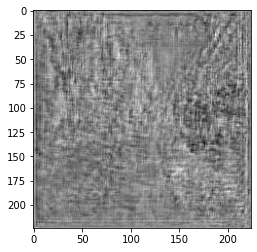

In [ ]:
# print output
plt.imshow(output.squeeze(), cmap='gray')

#### 3.2 Train the model

In [ ]:
# define loss function
criterion = smp.utils.losses.DiceLoss()

# define optimizer
optimizer = torch.optim.Adam([parameters for parameters in model.parameters() if parameters.requires_grad], lr=1e-3)

# define evaluation metric
metrics = [
    smp.utils.metrics.IoU(threshold=0.5)
]

In [ ]:
train_epoch = smp.utils.train.TrainEpoch(
    model, 
    loss=criterion, 
    metrics=metrics, 
    optimizer=optimizer,
    device='cuda',
    verbose=True,
)

val_epoch = smp.utils.train.ValidEpoch(
    model, 
    loss=criterion, 
    metrics=metrics, 
    device='cuda',
    verbose=True,
)

In [ ]:
# saving best model
max_score = 0

for i in range(0, 15):
    print('\nEpoch: {}'.format(i + 1))
    train_logs = train_epoch.run(train_loader)
    val_logs = val_epoch.run(val_loader)
    
    if max_score < val_logs['iou_score']:
        max_score = val_logs['iou_score']
        torch.save(model, './best_model.pth')
        print('Model saved!')

    # decreasing lr to fine tune model
    if i+1 == 10:
        optimizer.param_groups[0]['lr'] = 1e-5
        print('Decrease learning rate to 1e-5')


Epoch: 1
valid: 100%|██████████| 7/7 [00:02<00:00,  2.93it/s, dice_loss - 0.1671, iou_score - 0.8924]
Model saved!

Epoch: 2
valid: 100%|██████████| 7/7 [00:02<00:00,  2.88it/s, dice_loss - 0.1001, iou_score - 0.9131]
Model saved!

Epoch: 3
valid: 100%|██████████| 7/7 [00:02<00:00,  3.07it/s, dice_loss - 0.06097, iou_score - 0.939]
Model saved!

Epoch: 4
valid: 100%|██████████| 7/7 [00:02<00:00,  3.00it/s, dice_loss - 0.132, iou_score - 0.7903]

Epoch: 5
valid: 100%|██████████| 7/7 [00:02<00:00,  2.99it/s, dice_loss - 0.0406, iou_score - 0.9435]
Model saved!

Epoch: 6
valid: 100%|██████████| 7/7 [00:02<00:00,  3.13it/s, dice_loss - 0.03459, iou_score - 0.9497]
Model saved!

Epoch: 7
valid: 100%|██████████| 7/7 [00:02<00:00,  3.24it/s, dice_loss - 0.03035, iou_score - 0.9538]
Model saved!

Epoch: 8
valid: 100%|██████████| 7/7 [00:02<00:00,  3.05it/s, dice_loss - 0.03325, iou_score - 0.9454]

Epoch: 9
valid: 100%|██████████| 7/7 [00:02<00:00,  2.99it/s, dice_loss - 0.02831, iou_score - 

In [ ]:
# load best saved checkpoint
model = torch.load('./best_model.pth')

#### 2.3 Calculate IoU score

In [ ]:
# get sample data
image = Image.open('/content/data/CamVid/train/0006R0_f00930.png')
gt_mask = Image.open('/content/data/CamVid/trainannot/0006R0_f00930.png')

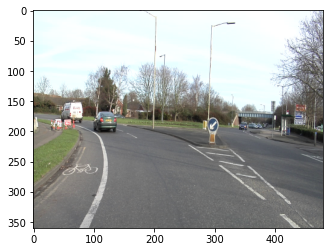

In [ ]:
plt.imshow(image)

In [ ]:
# preprocess mask
gt_mask = np.array(gt_mask)
gt_mask = (gt_mask == 3)
gt_mask = Image.fromarray(gt_mask)

# apply data augmentation
transform = Compose([
            Resize((224, 224)),
            ToTensor()
            ])
        
image = transform(image)

image = Compose([Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225])])(image)

gt_mask = transform(gt_mask)

In [ ]:
model.eval()
output = model(image.view(1, 3, 224, 224).to("cuda")).cpu().detach().numpy()

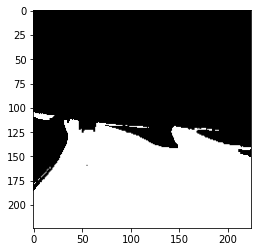

In [ ]:
plt.imshow(gt_mask.squeeze(), cmap='gray')

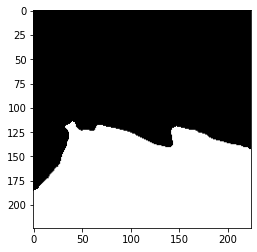

In [ ]:
plt.imshow((output.squeeze() > 0.5).astype(int), cmap='gray')

In [ ]:
# convert predicted mask to flattened numpy array
mask = (output.squeeze() > 0.5).astype(int)
pred = mask.ravel().copy()

# convert ground truth mask to flattened numpy array
gt_mask = gt_mask.cpu().detach().numpy()
target = gt_mask.ravel().copy().astype(int)

# get class indices for Lane
pred_inds = pred == 1
target_inds = target == 1

# calculate intersection
intersection = pred_inds[target_inds].sum()

# calculate union
union = pred_inds.sum() + target_inds.sum() - intersection

# get IoU score
iou = (float(intersection) / float(max(union, 1)))
iou

0.9681989155390552

#### 3.4 Inference on test dataset

In [ ]:
# run model for all images in test dataset
test_masks = []
model.eval()
with torch.no_grad():
    for test_image in test_dataset:
        mask = model(test_image.unsqueeze(0).to('cuda')).cpu().detach().numpy()
        test_masks.append(mask)

test_masks = (np.concatenate((test_masks), axis=0) > 0.5).astype(int)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


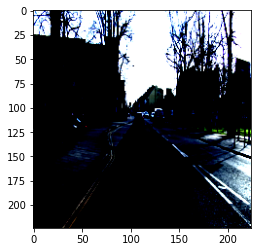

In [ ]:
# show original image
test_image = test_dataset[100]
plt.imshow(np.transpose(test_image, (1, 2, 0)))

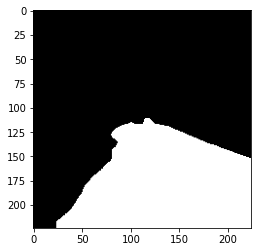

In [ ]:
# show prediction
plt.imshow((test_masks[100]).squeeze(), cmap='gray')